<h2>Importing required libraries

In [111]:
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import joblib
from sklearn.model_selection import KFold

In [112]:

pd.set_option('display.max_columns', 75)
pd.set_option('display.max_rows', 100)

In [113]:
df= pd.read_csv('footballer_data_cleaned.csv')


In [114]:
df.head()

,Age,Dribbling / Reflexes,Passing / Kicking,Shooting / Handling,International reputation,Total mentality,Shot power,Total power,Ball control,Finishing,Log Market Value
0,22,67,63,47,1,305,60,335,72,44,17.014184
1,19,76,71,70,1,99,53,218,18,8,15.520259
2,21,77,71,63,1,355,62,336,77,65,17.073607
3,18,67,67,53,1,295,60,327,71,51,15.068274
4,19,82,79,66,3,367,73,371,85,62,17.776324


# Linear Regression

<h3>Train test spilt

In [115]:
X= df.drop('Log Market Value', axis=1)
y= df['Log Market Value']

In [116]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

In [117]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape    

((2124, 10), (532, 10), (2124,), (532,))

In [118]:
y_train

891     15.384126
2243    12.524526
1134    14.557448
2625    13.217674
1610    15.068274
          ...    
1638    17.182806
1095    16.257858
1130    14.946913
1294    16.705882
860     15.894952
Name: Log Market Value, Length: 2124, dtype: float64

<h3>Scaling 

In [119]:
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train_scaled= scaler_X.fit_transform(X_train)
y_train_scaled= scaler_y.fit_transform(y_train.values.reshape(-1,1))
X_test_scaled= scaler_X.fit_transform(X_test)
y_test_scaled= scaler_y.fit_transform(y_test.values.reshape(-1,1))

In [120]:
y_train_scaled

array([[ 0.04739965],
       [-2.08978122],
       [-0.57043556],
       ...,
       [-0.27936107],
       [ 1.03524102],
       [ 0.42917567]])

In [121]:

joblib.dump(scaler_X, 'scaler_X.pkl')
joblib.dump(scaler_y, 'scaler_y.pkl')

['scaler_y.pkl']

In [122]:
X_train_scaled.shape, X_test.shape, y_train_scaled.shape, y_test.shape    

((2124, 10), (532, 10), (2124, 1), (532,))

<h3>Initializing weights and biases

In [123]:
w= torch.randn(X_train_scaled.shape[1],1)
b= torch.randn(1)


In [124]:
w.shape, b.shape

(torch.Size([10, 1]), torch.Size([1]))

In [125]:
X_train_scaled= torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_scaled= torch.tensor(y_train_scaled, dtype=torch.float32)

In [126]:
epochs= 250
lr= 0.01
train_loss=[]

for epoch in range(epochs):
    
    
    y_pred= X_train_scaled@ w+b
    Loss= y_pred-y_train_scaled

    n= len(y_train_scaled)

    mse= (1/n)*torch.sum(Loss**2)



    dw= (2/n)*(X_train_scaled.T@Loss)
    db= (2/n)*(torch.sum(Loss))

    w-= lr*dw
    b-= lr*db
    
        
    train_loss.append(mse.item())
    
    if epoch%100==0:
        print(f'Epoch {epoch+1}, Loss {mse.item()}')

Epoch 1, Loss 23.929916381835938
Epoch 101, Loss 0.6237858533859253
Epoch 201, Loss 0.38418906927108765


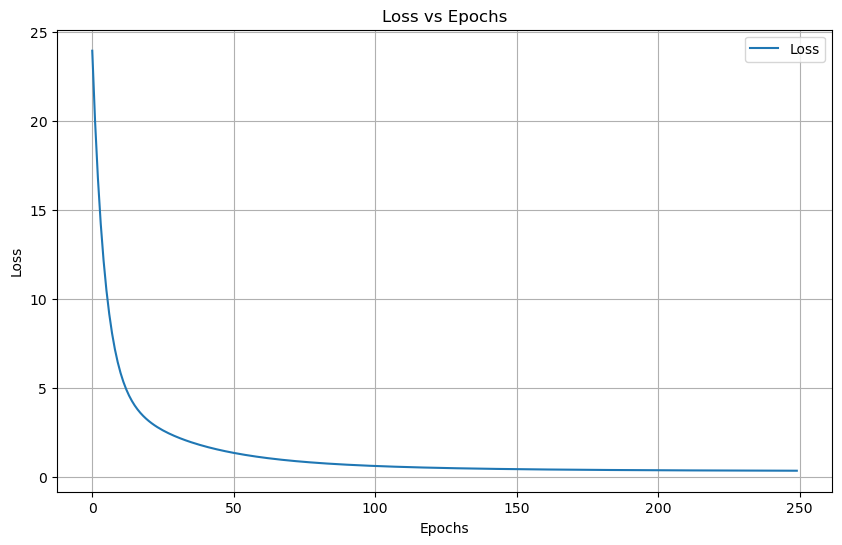

In [127]:
plt.figure(figsize=(10, 6))
plt.plot(range(epochs), train_loss, label="Loss")

plt.title("Loss vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()


# Validation

In [128]:
# R² Score Calculation
y_test_scaled = torch.tensor(y_test_scaled, dtype=torch.float32)
X_test_scaled = torch.tensor(X_test_scaled, dtype=torch.float32)

# Predictions on test data
y_pred = X_test_scaled @ w + b

# Compute R² score
ss_total = torch.sum((y_test_scaled[:, 0] - torch.mean(y_test_scaled[:, 0])) ** 2) #sum of squared error in the mean line
ss_residual = torch.sum((y_test_scaled[:, 0] - y_pred.squeeze()) ** 2) #sum of squared error in the regression line

r2_score = 1 - (ss_residual / ss_total)
print(f"R² Score: {r2_score.item()}")

R² Score: 0.6572085022926331


<h2>Cross Validation for MSE

In [129]:
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

X_scaled_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_scaled_tensor = torch.tensor(y_train_scaled, dtype=torch.float32)

cv_r2_scores = []
cv_mae_scores = []
cv_mse_scores = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X_scaled_tensor)):
    print(f"Fold {fold + 1}/{k}")
    
    # Split into train and validation sets
    X_train_fold = X_scaled_tensor[train_idx]
    y_train_fold = y_scaled_tensor[train_idx]
    X_val_fold = X_scaled_tensor[val_idx]
    y_val_fold = y_scaled_tensor[val_idx]
    
    # Initialize weights and bias
    w = torch.zeros((X_train_fold.shape[1], 1), dtype=torch.float32, requires_grad=False)
    b = torch.zeros(1, dtype=torch.float32, requires_grad=False)
    
    epochs = 2000
    lr = 0.01
    loss_history = []
    
    for epoch in range(epochs):
        # Predictions
        y_hat = X_train_fold @ w + b
        
        # Error
        error = y_hat - y_train_fold[:, 0:1]
        
        # MSE
        loss = torch.mean(error**2)
        loss_history.append(loss.item())
        
        # Gradients
        n = len(X_train_fold)
        grad_w = (1 / n) * (X_train_fold.T @ error)
        grad_b = torch.mean(error)
        
        w -= lr * grad_w
        b -= lr * grad_b
    
    # Validation predictions (scaled)
    y_val_pred = X_val_fold @ w + b
    
    # Transform predictions and actual values back to the original scale
    y_val_pred_scaled = scaler_y.inverse_transform(y_val_pred.detach().numpy())
    y_val_actual_scaled = scaler_y.inverse_transform(y_val_fold[:, 0].detach().numpy().reshape(-1, 1))
    
    y_val_pred_original = np.exp(y_val_pred_scaled) 
    y_val_actual_original = np.exp(y_val_actual_scaled)  
    
    # R² Calculation
    ss_total = np.sum((y_val_actual_original - np.mean(y_val_actual_original)) ** 2)
    ss_residual = np.sum((y_val_actual_original - y_val_pred_original) ** 2)
    r2_score = 1 - (ss_residual / ss_total)
    cv_r2_scores.append(r2_score)
    
    # MAE and MSE Calculation (after prediction, back to original scale)
    mae = np.mean(np.abs(y_val_actual_original - y_val_pred_original))
    mse = np.mean((y_val_actual_original - y_val_pred_original) ** 2)
    cv_mae_scores.append(mae)
    cv_mse_scores.append(mse)
    
    print(f"Fold {fold + 1} R²: {r2_score:.4f}, MAE: {mae:.4f}, MSE: {mse:.4f}")

# Average scores across folds
mean_r2_score = sum(cv_r2_scores) / len(cv_r2_scores)
mean_mae_score = sum(cv_mae_scores) / len(cv_mae_scores)
mean_mse_score = sum(cv_mse_scores) / len(cv_mse_scores)

print(f"\nAverage R² Across Folds: {mean_r2_score:.4f}")
print(f"Average MAE Across Folds: {mean_mae_score:.4f}")
print(f"Average MSE Across Folds: {mean_mse_score:.4f}")


Fold 1/5


/tmp/ipykernel_1718/967078122.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
/tmp/ipykernel_1718/967078122.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_scaled_tensor = torch.tensor(y_train_scaled, dtype=torch.float32)


Fold 1 R²: 0.6288, MAE: 5590333.0000, MSE: 110179425189888.0000
Fold 2/5
Fold 2 R²: 0.7434, MAE: 5377689.5000, MSE: 101177081462784.0000
Fold 3/5
Fold 3 R²: 0.3970, MAE: 5716121.0000, MSE: 147913724395520.0000
Fold 4/5
Fold 4 R²: 0.5651, MAE: 4764440.0000, MSE: 100100093247488.0000
Fold 5/5
Fold 5 R²: 0.5955, MAE: 4913557.0000, MSE: 97968564731904.0000

Average R² Across Folds: 0.5860
Average MAE Across Folds: 5272428.1000
Average MSE Across Folds: 111467777805516.7969


In [130]:
# Save the trained model


In [131]:
torch.save({'weights': w, 'bias': b}, 'linear_regression_model.pth')


In [132]:
stop.er

NameError: name 'stop' is not defined

# Inferencing 

In [ ]:
# Initialize empty list for features
feature_names = [
    "Age", "Dribbling / Reflexes", "Passing / Kicking", "Shooting / Handling",
    "International reputation", "Total mentality", "Shot power",
    "Total power", "Ball control", "Finishing"
]

# Collect user input for each feature
player_features = []
for feature in feature_names:
    value = float(input(f"Enter value for {feature}: "))
    player_features.append(value)

# Convert input to a NumPy array and reshape for scaling
player_features = np.array(player_features).reshape(1, -1)

# Scale the input features using the pre-fitted scaler
player_features_scaled = scaler_X.transform(player_features)

# Convert to PyTorch tensor
player_features_tensor = torch.tensor(player_features_scaled, dtype=torch.float32)

# Perform prediction in the log domain
log_market_value = player_features_tensor @ w + b

# Convert to NumPy and reverse scaling
log_market_value_numpy = log_market_value.detach().numpy().reshape(-1, 1)
predicted_value_scaled = scaler_y.inverse_transform(log_market_value_numpy)

# Convert back to PyTorch tensor to apply torch.exp
predicted_value_tensor = torch.tensor(predicted_value_scaled, dtype=torch.float32)
predicted_value = torch.exp(predicted_value_tensor)  # Reverse logarithmic transformation
predicted_value = predicted_value.item()  # Extract scalar value

print(f"Predicted Market Value: {predicted_value:.2f}")